# Lobbying in the 114th Congress
## This notebook downloads all industry donations data from OpenSecrets, parses into pandas dataframes for further visualization.
### Author: Rob Hammond
#### [Link](http://www.arcgis.com/apps/Cascade/index.html?appid=cc065fa2f6554a8ca036ea2947da3635) to final product



In [1]:
import os
import ijson
import pandas as pd
import seaborn as sns

from math import pi
from matplotlib import pyplot as plt
from bokeh.charts import Bar

from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LinearColorMapper, BasicTicker, NumeralTickFormatter, PrintfTickFormatter, ColorBar
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file

%matplotlib inline
# Commented out so that the notebook renders properly in GitHub
#output_notebook()

## Read in OpenSecrets Provided data
##### Note: This assumes we are only considering the 114th Congress
Link to OpenSecrets API documentation where this data can be found at the bottom: https://www.opensecrets.org/resources/create/api_doc.php

In [2]:
# It turns out that there a number of extra spaces in some of fields in various tables.
def strip(text):
    """
    Function to strip leading and trailing whitespaces from fields
    """
    try:
        return text.strip()
    except AttributeError:
        return text

In [3]:
member_cols = ['CID','CRPName','Party','FECCandID','Congress']
members = pd.read_csv('Members114.txt', sep='\t', names=member_cols, skiprows=1, index_col=False,
                     converters={'CID': strip,
                                 'CRPName': strip,
                                 'Party': strip,
                                 'FECCandID': strip,
                                 'Congress': strip})
members.head()

,CID,CRPName,Party,FECCandID,Congress
0,"N00036633,Abraham, Ralph,R,LA05,H4LA05221,House",,,,
1,"N00035451,Adams, Alma,D,NC12,H4NC12100,House",,,,
2,"N00003028,Aderholt, Robert B,R,AL04,H6AL04098,...",,,,
3,"N00033997,Aguilar, Pete,D,CA31,H2CA31125,House",,,,
4,"N00009888,Alexander, Lamar,R,TNS2,S2TN00058,Se...",,,,


In [4]:
committee_cols = ['CmteCode','CmteName','Congress']
committees = pd.read_csv('CommitteeCodes.txt', sep='\t', names=committee_cols, skiprows=1, index_col=False,
                        converters={'CmteCode': strip,
                                 'CmteName': strip,
                                 'Party': strip,
                                 'Congress': strip})
committees.head()

,CmteCode,CmteName,Congress
0,HADM,House Administration,House
1,HAGR,Agriculture,House
2,HAPP,Appropriations,House
3,HARM,Armed Services,House
4,HBAN,Banking,House


In [5]:
industry_cols = ['Catcode','Catname','Catorder','Industry','Sector','Sector Long']
industry = pd.read_csv('IndustryCodes.txt', sep='\t', names=industry_cols, skiprows=1, index_col=False,
                      converters={'Catcode': strip,
                                 'Catname': strip,
                                 'Catorder': strip,
                                 'Industry': strip,
                                 'Sector': strip,
                                 'Sector Long': strip})
industry.head()

,Catcode,Catname,Catorder,Industry,Sector,Sector Long
0,A0000,Agriculture,A11,Misc Agriculture,Agribusiness,Agribusiness
1,A1000,Crop production & basic processing,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
2,A1100,Cotton,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
3,A1200,Sugar cane & sugar beets,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
4,A1300,Tobacco & Tobacco products,A02,Tobacco,Agribusiness,Agribusiness


In [6]:
committees.CmteCode.nunique(), industry.Catorder.nunique()

(50, 103)

## Create functions to get OpenSecrets data

In [7]:
def get_cmte_by_ind(session=114, industry='F10', cmte='HARM', output='json', api_key='key'):
    """
    This downloads the committee funding by specified industry for a given session of congress.
    Only 112 through 114 available at this time.
    """
    filename='committee_funding/' + cmte + '_' + industry + '_' + str(session) + '.' + output
    request = str('wget -O committee_funding/' + cmte + '_' + industry + '_' + str(session) + '.json' + \
        " 'https://www.opensecrets.org/api/?method=congCmteIndus&congno=" + str(session) + \
        '&indus=' + industry + '&cmte=' + cmte + '&output=' + output + '&apikey=' + api_key + "'")
    os.system(request)
    
    return filename

def download_files(session=114, inds=['inds'], cmtes=['cmtes'], output='json', api_key='key'):
    """
    This will take a list of industries and committees and download 
    all the relevant files from OpenSecrets.
    """
    invalid = list()
    valid = list()
    for c in cmtes:
        for i in inds:
            # Check to see if file is already downloaded
            # If it isn't then download it
            filename = 'committee_funding/' + c + '_' + i + '_' + str(session) + '.' + output
            if os.path.isfile(filename):
                if os.path.getsize(filename) == 0:
                    invalid.append(filename)
                else:
                    valid.append(filename)
            else:
                filename = get_cmte_by_ind(session=114, industry=i, cmte=c, output='json', api_key=api_key)
                # If there is no data in the file, then delete it, but keep filename in
                # a separate list for spot checking later
                if os.path.getsize(filename) == 0:
                    invalid.append(filename)
                else:
                    valid.append(filename)
    return valid, invalid

In [8]:
cmtes = list(committees.CmteCode.unique()) # committee codes
inds = list(industry.Catorder.unique()) # industry codes
key='2f80d6c32b79482b52d37fb715302968' # your API key

# store all valid and invalid files in a list
valid, invalid = download_files(session=114, inds=inds, cmtes=cmtes, api_key=key)

In [9]:
len(valid), len(invalid), len(valid) + len(invalid)

(2937, 2213, 5150)

## Parse the data

In [10]:
def parse(filename='path/filename'):
    """
    This function parses the committee lobbying data file and returns a list of lists for every 
    contribution in each file's the committe/industry combination
    """
    
    # Get the individual pieces from the filename
    cmte, ind, sess = filename.split('/')[1].split('_') 
    sess = sess[:3]
    mem_list = []
    
    try:
        with open(filename, 'r') as f:
            objects = list(ijson.items(f, 'response.committee.member'))[0]
            members = [o['@attributes'] for o in objects]
            for m in members:
                mem_list.append([sess, cmte, ind, m['cid'],m['member_name'],m['party'],m['state'],m['indivs'],m['pacs'],m['total']])
    except:
        with open(filename, 'r') as f:
            objects = list(ijson.items(f, 'response.committee.member'))[0]
            m = objects['@attributes']
            mem_list.append([sess, cmte, ind, m['cid'],m['member_name'],m['party'],m['state'],m['indivs'],m['pacs'],m['total']])

    return mem_list

In [11]:
columns = ['session','CmteCode','Catorder','CID','CRPName','party','state', \
           'individual_donations','pac_donations','total_donations'] # column names

# create a list of lists of all committees, industries, and congress members
lobby = []
for val in valid:
    print (val)
    v_list = parse(val)
    for v in v_list:
        lobby.append(v)


committee_funding/HADM_A01_114.json
committee_funding/HADM_A02_114.json
committee_funding/HADM_A04_114.json
committee_funding/HADM_A05_114.json
committee_funding/HADM_A06_114.json
committee_funding/HADM_A07_114.json
committee_funding/HADM_A10_114.json
committee_funding/HADM_C01_114.json
committee_funding/HADM_C02_114.json
committee_funding/HADM_C03_114.json
committee_funding/HADM_C04_114.json
committee_funding/HADM_C05_114.json
committee_funding/HADM_B01_114.json
committee_funding/HADM_B02_114.json
committee_funding/HADM_B09_114.json
committee_funding/HADM_B08_114.json
committee_funding/HADM_B12_114.json
committee_funding/HADM_B13_114.json
committee_funding/HADM_D03_114.json
committee_funding/HADM_D01_114.json
committee_funding/HADM_D02_114.json
committee_funding/HADM_E01_114.json
committee_funding/HADM_E04_114.json
committee_funding/HADM_E08_114.json
committee_funding/HADM_E10_114.json
committee_funding/HADM_F13_114.json
committee_funding/HADM_F03_114.json
committee_funding/HADM_F04_1

committee_funding/HAPP_Q16_114.json
committee_funding/HARM_A01_114.json
committee_funding/HARM_A02_114.json
committee_funding/HARM_A04_114.json
committee_funding/HARM_A05_114.json
committee_funding/HARM_A06_114.json
committee_funding/HARM_A07_114.json
committee_funding/HARM_A10_114.json
committee_funding/HARM_C01_114.json
committee_funding/HARM_C02_114.json
committee_funding/HARM_C03_114.json
committee_funding/HARM_C04_114.json
committee_funding/HARM_C05_114.json
committee_funding/HARM_B01_114.json
committee_funding/HARM_B02_114.json
committee_funding/HARM_B09_114.json
committee_funding/HARM_B08_114.json
committee_funding/HARM_B12_114.json
committee_funding/HARM_B13_114.json
committee_funding/HARM_D03_114.json
committee_funding/HARM_D01_114.json
committee_funding/HARM_D02_114.json
committee_funding/HARM_E01_114.json
committee_funding/HARM_E04_114.json
committee_funding/HARM_E08_114.json
committee_funding/HARM_E10_114.json
committee_funding/HARM_F13_114.json
committee_funding/HARM_F03_1

committee_funding/HENE_B09_114.json
committee_funding/HENE_B08_114.json
committee_funding/HENE_B12_114.json
committee_funding/HENE_B13_114.json
committee_funding/HENE_D03_114.json
committee_funding/HENE_D01_114.json
committee_funding/HENE_D02_114.json
committee_funding/HENE_E01_114.json
committee_funding/HENE_E04_114.json
committee_funding/HENE_E08_114.json
committee_funding/HENE_E10_114.json
committee_funding/HENE_F13_114.json
committee_funding/HENE_F03_114.json
committee_funding/HENE_F04_114.json
committee_funding/HENE_F05_114.json
committee_funding/HENE_F06_114.json
committee_funding/HENE_F07_114.json
committee_funding/HENE_F09_114.json
committee_funding/HENE_F10_114.json
committee_funding/HENE_F11_114.json
committee_funding/HENE_N00_114.json
committee_funding/HENE_A09_114.json
committee_funding/HENE_N01_114.json
committee_funding/HENE_N02_114.json
committee_funding/HENE_N03_114.json
committee_funding/HENE_N04_114.json
committee_funding/HENE_N05_114.json
committee_funding/HENE_N06_1

committee_funding/HHSC_Q04_114.json
committee_funding/HHSC_Q05_114.json
committee_funding/HHSC_Q13_114.json
committee_funding/HHSC_Q09_114.json
committee_funding/HHSC_Q14_114.json
committee_funding/HHSC_Q15_114.json
committee_funding/HHSC_Q08_114.json
committee_funding/HHSC_Q11_114.json
committee_funding/HHSC_K01_114.json
committee_funding/HHSC_K02_114.json
committee_funding/HHSC_P05_114.json
committee_funding/HHSC_P04_114.json
committee_funding/HHSC_P01_114.json
committee_funding/HHSC_P02_114.json
committee_funding/HHSC_P03_114.json
committee_funding/HHSC_N15_114.json
committee_funding/HHSC_N13_114.json
committee_funding/HHSC_N14_114.json
committee_funding/HHSC_N16_114.json
committee_funding/HHSC_M01_114.json
committee_funding/HHSC_M02_114.json
committee_funding/HHSC_M03_114.json
committee_funding/HHSC_M04_114.json
committee_funding/HHSC_M05_114.json
committee_funding/HHSC_N08_114.json
committee_funding/HHSC_W06_114.json
committee_funding/HHSC_W03_114.json
committee_funding/HHSC_W02_1

committee_funding/HRES_N14_114.json
committee_funding/HRES_N16_114.json
committee_funding/HRES_M01_114.json
committee_funding/HRES_M02_114.json
committee_funding/HRES_M03_114.json
committee_funding/HRES_M04_114.json
committee_funding/HRES_M05_114.json
committee_funding/HRES_N08_114.json
committee_funding/HRES_W06_114.json
committee_funding/HRES_W03_114.json
committee_funding/HRES_W02_114.json
committee_funding/HRES_W05_114.json
committee_funding/HRES_Q16_114.json
committee_funding/HRUL_A01_114.json
committee_funding/HRUL_A02_114.json
committee_funding/HRUL_A04_114.json
committee_funding/HRUL_A05_114.json
committee_funding/HRUL_A06_114.json
committee_funding/HRUL_A07_114.json
committee_funding/HRUL_A10_114.json
committee_funding/HRUL_C01_114.json
committee_funding/HRUL_C02_114.json
committee_funding/HRUL_C03_114.json
committee_funding/HRUL_C04_114.json
committee_funding/HRUL_C05_114.json
committee_funding/HRUL_B01_114.json
committee_funding/HRUL_B02_114.json
committee_funding/HRUL_B09_1

committee_funding/HSMA_P04_114.json
committee_funding/HSMA_P01_114.json
committee_funding/HSMA_P02_114.json
committee_funding/HSMA_P03_114.json
committee_funding/HSMA_N15_114.json
committee_funding/HSMA_N13_114.json
committee_funding/HSMA_N14_114.json
committee_funding/HSMA_N16_114.json
committee_funding/HSMA_M01_114.json
committee_funding/HSMA_M02_114.json
committee_funding/HSMA_M03_114.json
committee_funding/HSMA_M04_114.json
committee_funding/HSMA_M05_114.json
committee_funding/HSMA_N08_114.json
committee_funding/HSMA_W06_114.json
committee_funding/HSMA_W03_114.json
committee_funding/HSMA_W02_114.json
committee_funding/HSMA_W05_114.json
committee_funding/HSMA_Q16_114.json
committee_funding/HTRA_A01_114.json
committee_funding/HTRA_A02_114.json
committee_funding/HTRA_A04_114.json
committee_funding/HTRA_A05_114.json
committee_funding/HTRA_A06_114.json
committee_funding/HTRA_A07_114.json
committee_funding/HTRA_A10_114.json
committee_funding/HTRA_C01_114.json
committee_funding/HTRA_C02_1

committee_funding/HWAY_W03_114.json
committee_funding/HWAY_W02_114.json
committee_funding/HWAY_W05_114.json
committee_funding/HWAY_Q16_114.json
committee_funding/SAGR_A01_114.json
committee_funding/SAGR_A02_114.json
committee_funding/SAGR_A04_114.json
committee_funding/SAGR_A05_114.json
committee_funding/SAGR_A06_114.json
committee_funding/SAGR_A07_114.json
committee_funding/SAGR_A10_114.json
committee_funding/SAGR_C01_114.json
committee_funding/SAGR_C02_114.json
committee_funding/SAGR_C03_114.json
committee_funding/SAGR_C04_114.json
committee_funding/SAGR_C05_114.json
committee_funding/SAGR_B01_114.json
committee_funding/SAGR_B02_114.json
committee_funding/SAGR_B09_114.json
committee_funding/SAGR_B08_114.json
committee_funding/SAGR_B12_114.json
committee_funding/SAGR_B13_114.json
committee_funding/SAGR_D03_114.json
committee_funding/SAGR_D01_114.json
committee_funding/SAGR_D02_114.json
committee_funding/SAGR_E01_114.json
committee_funding/SAGR_E04_114.json
committee_funding/SAGR_E08_1

committee_funding/SBAN_E08_114.json
committee_funding/SBAN_E10_114.json
committee_funding/SBAN_F13_114.json
committee_funding/SBAN_F03_114.json
committee_funding/SBAN_F04_114.json
committee_funding/SBAN_F05_114.json
committee_funding/SBAN_F06_114.json
committee_funding/SBAN_F07_114.json
committee_funding/SBAN_F09_114.json
committee_funding/SBAN_F10_114.json
committee_funding/SBAN_F11_114.json
committee_funding/SBAN_N00_114.json
committee_funding/SBAN_A09_114.json
committee_funding/SBAN_N01_114.json
committee_funding/SBAN_N02_114.json
committee_funding/SBAN_N03_114.json
committee_funding/SBAN_N04_114.json
committee_funding/SBAN_N05_114.json
committee_funding/SBAN_N06_114.json
committee_funding/SBAN_N07_114.json
committee_funding/SBAN_H01_114.json
committee_funding/SBAN_H02_114.json
committee_funding/SBAN_H03_114.json
committee_funding/SBAN_H04_114.json
committee_funding/SBAN_W04_114.json
committee_funding/SBAN_Q01_114.json
committee_funding/SBAN_Q02_114.json
committee_funding/SBAN_Q03_1

committee_funding/SENE_C01_114.json
committee_funding/SENE_C02_114.json
committee_funding/SENE_C03_114.json
committee_funding/SENE_C04_114.json
committee_funding/SENE_C05_114.json
committee_funding/SENE_B01_114.json
committee_funding/SENE_B02_114.json
committee_funding/SENE_B09_114.json
committee_funding/SENE_B08_114.json
committee_funding/SENE_B12_114.json
committee_funding/SENE_B13_114.json
committee_funding/SENE_D03_114.json
committee_funding/SENE_D01_114.json
committee_funding/SENE_D02_114.json
committee_funding/SENE_E01_114.json
committee_funding/SENE_E04_114.json
committee_funding/SENE_E08_114.json
committee_funding/SENE_E10_114.json
committee_funding/SENE_F13_114.json
committee_funding/SENE_F03_114.json
committee_funding/SENE_F04_114.json
committee_funding/SENE_F05_114.json
committee_funding/SENE_F06_114.json
committee_funding/SENE_F07_114.json
committee_funding/SENE_F09_114.json
committee_funding/SENE_F10_114.json
committee_funding/SENE_F11_114.json
committee_funding/SENE_N00_1

committee_funding/SFOR_P01_114.json
committee_funding/SFOR_P02_114.json
committee_funding/SFOR_P03_114.json
committee_funding/SFOR_N15_114.json
committee_funding/SFOR_N13_114.json
committee_funding/SFOR_N14_114.json
committee_funding/SFOR_N16_114.json
committee_funding/SFOR_M01_114.json
committee_funding/SFOR_M02_114.json
committee_funding/SFOR_M03_114.json
committee_funding/SFOR_M04_114.json
committee_funding/SFOR_M05_114.json
committee_funding/SFOR_N08_114.json
committee_funding/SFOR_W06_114.json
committee_funding/SFOR_W03_114.json
committee_funding/SFOR_W02_114.json
committee_funding/SFOR_W05_114.json
committee_funding/SFOR_Q16_114.json
committee_funding/SGOV_A01_114.json
committee_funding/SGOV_A02_114.json
committee_funding/SGOV_A04_114.json
committee_funding/SGOV_A05_114.json
committee_funding/SGOV_A06_114.json
committee_funding/SGOV_A07_114.json
committee_funding/SGOV_A10_114.json
committee_funding/SGOV_C01_114.json
committee_funding/SGOV_C02_114.json
committee_funding/SGOV_C03_1

committee_funding/SLAB_B08_114.json
committee_funding/SLAB_B12_114.json
committee_funding/SLAB_B13_114.json
committee_funding/SLAB_D03_114.json
committee_funding/SLAB_D01_114.json
committee_funding/SLAB_D02_114.json
committee_funding/SLAB_E01_114.json
committee_funding/SLAB_E04_114.json
committee_funding/SLAB_E08_114.json
committee_funding/SLAB_E10_114.json
committee_funding/SLAB_F13_114.json
committee_funding/SLAB_F03_114.json
committee_funding/SLAB_F04_114.json
committee_funding/SLAB_F05_114.json
committee_funding/SLAB_F06_114.json
committee_funding/SLAB_F07_114.json
committee_funding/SLAB_F09_114.json
committee_funding/SLAB_F10_114.json
committee_funding/SLAB_F11_114.json
committee_funding/SLAB_N00_114.json
committee_funding/SLAB_A09_114.json
committee_funding/SLAB_N01_114.json
committee_funding/SLAB_N02_114.json
committee_funding/SLAB_N03_114.json
committee_funding/SLAB_N04_114.json
committee_funding/SLAB_N05_114.json
committee_funding/SLAB_N06_114.json
committee_funding/SLAB_N07_1

committee_funding/SVET_N01_114.json
committee_funding/SVET_N02_114.json
committee_funding/SVET_N03_114.json
committee_funding/SVET_N04_114.json
committee_funding/SVET_N05_114.json
committee_funding/SVET_N06_114.json
committee_funding/SVET_N07_114.json
committee_funding/SVET_H01_114.json
committee_funding/SVET_H02_114.json
committee_funding/SVET_H03_114.json
committee_funding/SVET_H04_114.json
committee_funding/SVET_W04_114.json
committee_funding/SVET_Q01_114.json
committee_funding/SVET_Q02_114.json
committee_funding/SVET_Q03_114.json
committee_funding/SVET_Q04_114.json
committee_funding/SVET_Q05_114.json
committee_funding/SVET_Q12_114.json
committee_funding/SVET_Q13_114.json
committee_funding/SVET_Q09_114.json
committee_funding/SVET_Q14_114.json
committee_funding/SVET_Q15_114.json
committee_funding/SVET_Q08_114.json
committee_funding/SVET_Q11_114.json
committee_funding/SVET_K01_114.json
committee_funding/SVET_K02_114.json
committee_funding/SVET_P05_114.json
committee_funding/SVET_P04_1

## Create a DataFrame and output as a .csv file
##### Note: This will be combined with the lists of committees and and insdustries outside of this program as pandas was not behaving as expected when joining the data. Could be fixed in further refinement processes

In [12]:
df = pd.DataFrame(lobby, columns=columns)
df['chamber'] = ['House' if x[0] == 'H' else 'Senate' for x in df['CmteCode']]
df.head()

,session,CmteCode,Catorder,CID,CRPName,party,state,individual_donations,pac_donations,total_donations,chamber
0,114,HADM,A01,N00034784,"Davis, Rodney",R,Illinois,20685,71750,92435,House
1,114,HADM,A01,N00036023,"Comstock, Barbara",R,Virginia,15150,26000,41150,House
2,114,HADM,A01,N00029632,"Harper, Gregg",R,Mississippi,5100,23000,28100,House
3,114,HADM,A01,N00007021,"Vargas, Juan",D,California,1000,23000,24000,House
4,114,HADM,A01,N00007479,"Lofgren, Zoe",D,California,3000,17200,20200,House


In [13]:
# Seems that that there are multiple committee names for the same committee
# For instance the House Banking and Finance committee are the same, but Finance is the prefered reference
for c in committees.CmteCode.unique().tolist():
    if c not in df.CmteCode.unique().tolist():
        print (c)

HBAN
HCOM
HEGW
HITL
HPRC
HSTA
JECO
JLIB
JPRI
JTAX
SAGI
SETH
SITL
STEC


In [14]:
# After checking a few this seems to be ok
for c in industry.Catorder.unique().tolist():
    if c not in df.Catorder.unique().tolist():
        print (c) 

A11
B00
E07
E09
E11
N12
N09
H05
W07
Q10
M06
Y00
Y01
Y02
Y03
Y04
Z04
Z02
Z07
Z08
Z09


In [15]:
# Ensure data types match what is expected
df.individual_donations = df.individual_donations.astype(int)
df.pac_donations = df.pac_donations.astype(int)
df.total_donations = df.total_donations.astype(int)
df.dtypes

session                 object
CmteCode                object
Catorder                object
CID                     object
CRPName                 object
party                   object
state                   object
individual_donations     int64
pac_donations            int64
total_donations          int64
chamber                 object
dtype: object

In [16]:
# Check original number committees, industries, and thier combinations
len(industry.Catorder.unique()), len(committees.CmteCode.unique()), len(industry.Catorder.unique())*len(committees.CmteCode.unique())

(103, 50, 5150)

In [17]:
# Check extracted number committees, industries, and thier combinations
len(df.Catorder.unique()), len(df.CmteCode.unique()), len(df.Catorder.unique())*len(df.CmteCode.unique())

(82, 36, 2952)

In [18]:
# Output to .csv
df.to_csv('legislator_committee_lobbying.csv', index=False)

## Output only the industry total contributions to each committee

In [19]:
df.groupby(['CmteCode','Catorder'])['total_donations'].sum().to_csv('committee_by_industry.tsv', sep='\t', header=True, index_label=['committee','industry'])
lob = pd.read_csv('committee_by_industry.tsv', sep='\t', index_col=False, header=0)
cmte = lob.committee.unique().tolist()
ind = lob.industry.unique().tolist()
lob.shape

(2937, 3)

In [20]:
new_com_ind = []
for c in df.CmteCode.unique().tolist():
    for i in df.Catorder.unique().tolist():
        try:
            new_com_ind.append([c,i,lob[(lob.committee==c) & (lob.industry==i)].total_donations.values[0]])
        except:
            new_com_ind.append([c,i,0])
new_df = pd.DataFrame(new_com_ind, columns=['committee','industry','donations'])
new_df.to_csv('committee_by_industry.tsv', sep='\t', index=False)
new_df.head()

,committee,industry,donations
0,HADM,A01,218385
1,HADM,A02,28500
2,HADM,A04,24486
3,HADM,A05,16900
4,HADM,A06,38900


In [21]:
new_df.committee.nunique(), new_df.industry.nunique()

(36, 82)

## Find committee interactions for D3 hierarchical chord visualization
##### Note: Outside manipulations took place to convert names to the form we see. There are also multiple instances of names that have been manually changed because their FEC ID did not match their chamber assignment because they ran for another office. (See Bernie Sanders, Tammy Duckworth, and ~15 others).

In [22]:
# Committee_Interactions.csv is just a csv of committee codes and modified
# legislator names to look like Chamber.Party.First_MI_Last
interactions = pd.read_csv('Committee_Interactions.csv', index_col=False, header=0)
interactions.head() 


,committee,member_name,manually_changed,reason
0,HADM,House.R.Rodney_Davis,0,NaN
1,HADM,House.R.Barbara_Comstock,0,NaN
2,HADM,House.R.Gregg_Harper,0,NaN
3,HADM,House.D.Juan_Vargas,0,NaN
4,HADM,House.D.Zoe_Lofgren,0,NaN


In [23]:
interactions.committee.unique()

array(['HADM', 'HAGR', 'HAPP', 'HARM', 'HBUD', 'HEDU', 'HENE', 'HFIN',
       'HGOV', 'HHSC', 'HINT', 'HJUD', 'HRES', 'HRUL', 'HSCI', 'HSMA',
       'HTRA', 'HVET', 'HWAY', 'SAGR', 'SAPP', 'SARM', 'SBAN', 'SBUD',
       'SCOM', 'SENE', 'SENV', 'SFIN', 'SFOR', 'SGOV', 'SIND', 'SJUD',
       'SLAB', 'SRUL', 'SSMA', 'SVET'], dtype=object)

In [24]:
sen_com = [] # senate committees
house_com = [] # house committees
house_memb = [] # house members
sen_memb = [] # senate members
sen_coms = {} # senate committees and their members
house_coms = {} # house committees and their members
all_coms = {} # all committeess and their members

# create committee lists
for c in interactions.committee.tolist():
    if c [0] == 'H'and c not in house_com:
        house_com.append(c)
    if c [0] == 'S'and c not in sen_com:
        sen_com.append(c)
all_com = interactions.committee.unique().tolist() # all committess (includes joint committees)
house_com = sorted(house_com)
sen_com = sorted(sen_com)
all_com = sorted(all_com)
print (len(sen_com), len(house_com), len(all_com))

# create member lists
for m in interactions.member_name.unique().tolist():
    if m[0] == 'H':
        house_memb.append(m)
    if m[0] == 'S':
        sen_memb.append(m)
all_memb = interactions.member_name.unique().tolist() # all members of congress
house_memb = sorted(house_memb)
sen_memb = sorted(sen_memb)
all_memb = sorted(all_memb)
print (len(sen_memb), len(house_memb), len(all_memb))

# create dictionary of house committees and their members
for c in house_com:
    house_coms[c] = []
    h_memb = interactions[interactions.committee == c].member_name.tolist()
    for cm in house_memb:
        if cm not in house_coms[c]:
            house_coms[c].append(cm)

# create dictionary of senate committees and their members
for c in sen_com:
    sen_coms[c] = []
    s_memb = interactions[interactions.committee == c].member_name.tolist()
    for cm in s_memb:
        if cm not in sen_coms[c]:
            sen_coms[c].append(cm)
# create dictionary of senate committees and their members
for c in all_com:
    all_coms[c] = []
    a_memb = interactions[interactions.committee == c].member_name.tolist()
    for cm in a_memb:
        if cm not in all_coms[c]:
            all_coms[c].append(cm)

17 19 36
99 431 530


In [25]:
# Create a separate dictionary for each of the house and senate committee
# member interactions to write to a .json file
keys = ['name','size','comembers']
house_output = []
sen_output = []
all_output = []
# Create a list of dictionaries of house member interactions
for mem in house_memb:
    member_interactions = dict.fromkeys(keys, None)
    member_interactions['name'] = mem    
    com_list = interactions[interactions.member_name == mem].committee.unique().tolist()
    member_interactions['size'] = len(com_list)
    member_interactions['comembers'] = []
    for c in com_list:
        if c[0] == 'H':
            for m in interactions[interactions.committee == c].member_name.unique().tolist():
                if m not in member_interactions['comembers'] and m != mem:
                    member_interactions['comembers'].append(m)
    house_output.append(member_interactions)
print("house output data created")
    
# Create a list of dictionaries of senate member interactions
for mem in sen_memb:
    member_interactions = dict.fromkeys(keys, None)
    member_interactions['name'] = mem    
    com_list = interactions[interactions.member_name == mem].committee.unique().tolist()
    member_interactions['size'] = len(com_list)
    member_interactions['comembers'] = []
    for c in com_list:
        if c[0] == 'S':
            for m in interactions[interactions.committee == c].member_name.unique().tolist():
                if m not in member_interactions['comembers'] and m != mem:
                    member_interactions['comembers'].append(m)
    sen_output.append(member_interactions)
print("senate output data created")

# Create a list of dictionaries of all congress member interactions
for mem in all_memb:
    member_interactions = dict.fromkeys(keys, None)
    member_interactions['name'] = mem    
    com_list = interactions[interactions.member_name == mem].committee.unique().tolist()
    member_interactions['size'] = len(com_list)
    member_interactions['comembers'] = []
    for c in com_list:
        for m in interactions[interactions.committee == c].member_name.unique().tolist():
            if m not in member_interactions['comembers'] and m != mem:
                member_interactions['comembers'].append(m)
    all_output.append(member_interactions)
print ("all member output data created")

house output data created
senate output data created
all member output data created


In [26]:
# Write outputs to file

out = open('house_member_interactions.json', 'w')
out.write("[\n")
for i in range(len(house_output)):
    comembers = str('[')
    for j in range(len(house_output[i]['comembers'])):
        comembers = str(comembers+'"'+house_output[i]['comembers'][j]+'"')
        if j != len(house_output[i]['comembers'])-1:
            comembers = str(comembers+',')
    comembers = str(comembers+"]")
    line = str('{"name":"'+house_output[i]['name']+'","size":'+str(house_output[i]['size'])+',"comembers":'+comembers+'}')
    if i != len(house_output)-1:
        line = str(line+',\n')
    else:
        line = str(line+'\n')
    out.write(line)
out.write("]")
out.close()

out = open('senate_member_interactions.json', 'w')
out.write("[\n")
for i in range(len(sen_output)):
    comembers = str('[')
    for j in range(len(sen_output[i]['comembers'])):
        comembers = str(comembers+'"'+sen_output[i]['comembers'][j]+'"')
        if j != len(sen_output[i]['comembers'])-1:
            comembers = str(comembers+',')
    comembers = str(comembers+"]")
    line = str('{"name":"'+sen_output[i]['name']+'","size":'+str(sen_output[i]['size'])+',"comembers":'+comembers+'}')
    if i != len(sen_output)-1:
        line = str(line+',\n')
    else:
        line = str(line+'\n')
    out.write(line)
out.write("]")
out.close()

out = open('all_member_interactions.json', 'w')
out.write("[\n")
for i in range(len(all_output)):
    comembers = str('[')
    for j in range(len(all_output[i]['comembers'])):
        comembers = str(comembers+'"'+all_output[i]['comembers'][j]+'"')
        if j != len(all_output[i]['comembers'])-1:
            comembers = str(comembers+',')
    comembers = str(comembers+"]")
    line = str('{"name":"'+all_output[i]['name']+'","size":'+str(all_output[i]['size'])+',"comembers":'+comembers+'}')
    if i != len(all_output)-1:
        line = str(line+',\n')
    else:
        line = str(line+'\n')
    out.write(line)
out.write("]")
out.close()

print ("Done")

Done


## Plot the distribution of House and Senate connections to other members
##### Note: only considers unique connections and ignores when members are comembers on more than one committee, though that would be interesting to consider for the future

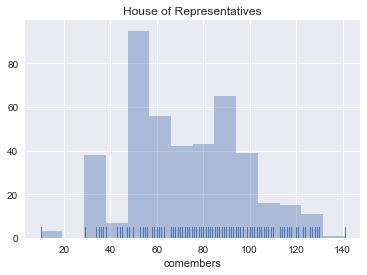

In [27]:
house_connections = []
for i in range(len(house_output)):
    house_connections.append([house_output[i]["name"], len(house_output[i]["comembers"]), house_output[i]["size"]])
hc = pd.DataFrame(house_connections, columns=['member','comembers', 'committees'])
sns.distplot(hc.comembers, kde=False, rug=True);
plt.title("House of Representatives")
plt.show()
plt.savefig('visualizations/house_comember_histogram.jpg')

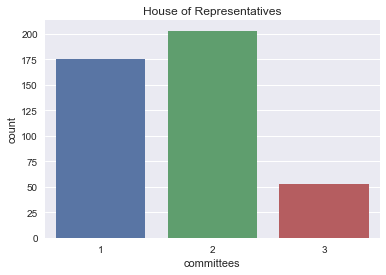

In [28]:
sns.countplot(x="committees", data=hc)
plt.title("House of Representatives")
plt.show()
plt.savefig('visualizations/house_committee_histogram.jpg')

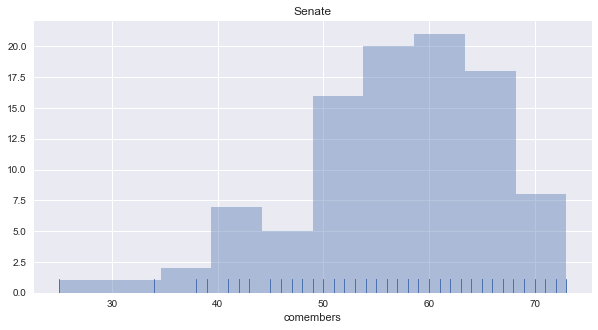

In [29]:
sen_connections = []
for i in range(len(sen_output)):
    sen_connections.append([sen_output[i]["name"], len(sen_output[i]["comembers"]), sen_output[i]["size"]])
sc = pd.DataFrame(sen_connections, columns=['member','comembers', 'committees'])
plt.figure(figsize=(10,5))
plt.title("Senate")
sns.distplot(sc.comembers,kde=False,rug=True);
plt.show()
plt.savefig('visualizations/senate_comember_histogram.png')

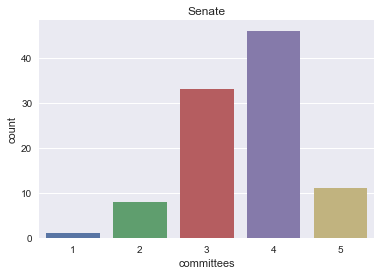

In [30]:
sns.countplot(x="committees", data=sc);
plt.title("Senate")
plt.show()
plt.savefig('visualizations/senate_committee_histogram.png')

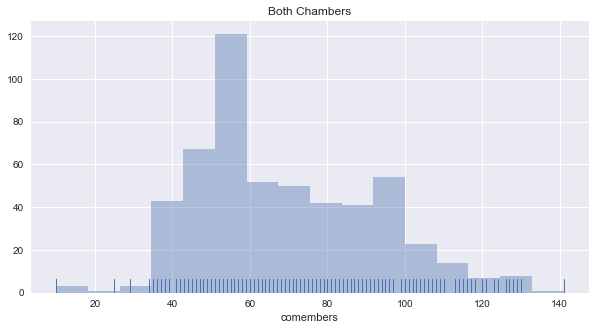

In [44]:
all_connections = []
for i in range(len(all_output)):
    all_connections.append([all_output[i]["name"], len(all_output[i]["comembers"]), all_output[i]["size"]])
ac = pd.DataFrame(all_connections, columns=['member','comembers','committees'])
plt.figure(figsize=(10,5))
plt.title("Both Chambers")
sns.distplot(ac.comembers, kde=False, rug=True);
plt.show()
plt.savefig('visualizations/all_members_comembership.png')

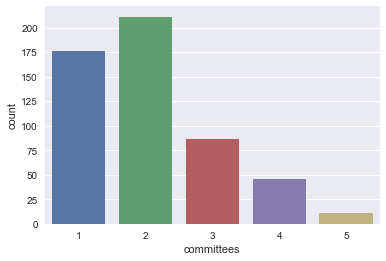

In [32]:
plt.title("Both Chambers")
sns.countplot(x="committees", data=ac)
plt.savefig('visualizations/all_members_committee_dist.png')
plt.show()

In [33]:
# #feelthebern
sc[sc.committees == 5]

,member,comembers,committees
19,Senate.D.Heidi_Heitkamp,65,5
25,Senate.D.Jon_Tester,66,5
27,Senate.D.Maria_Cantwell,69,5
42,Senate.D.Tom_Udall,67,5
44,Senate.I.Bernie_Sanders,68,5
61,Senate.R.Jerry_Moran,70,5
63,Senate.R.John_Boozman,69,5
70,Senate.R.Kelly_Ayotte,66,5
76,Senate.R.Mike_Crapo,69,5
77,Senate.R.Mike_Enzi,67,5


## Visualize the relationship between industries and committees and sectors and committees
#### Visualization can be found on jsfiddle at: 
##### Note: Some outside manipulation of fields took place to attach industry names, sector names, and committee names. Again, pandas was not behaving as expected

In [34]:
df_com_donation = pd.read_csv('committee_by_industry_names.tsv', sep='\t', index_col=False, header=0)
df_com_donation['sect_ind'] = df_com_donation.sector + " - " + df_com_donation.industry_name
df_com_donation.donations = df_com_donation.donations.astype(int)
df_com_donation.groupby(['committee_name','sect_ind'])['donations'].sum().to_csv('com_ind_donations.tsv', sep='\t', header=True, index_label=['committee_name','sect_ind'])
df_com_donation.head()

,committee,committee_name,industry,industry_name,sector,donations,sect_ind
0,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,218385,Agribusiness - Crop Production & Basic Processing
1,HADM,House Administration (H),A02,Tobacco,Agribusiness,28500,Agribusiness - Tobacco
2,HADM,House Administration (H),A04,Dairy,Agribusiness,24486,Agribusiness - Dairy
3,HADM,House Administration (H),A05,Poultry & Eggs,Agribusiness,16900,Agribusiness - Poultry & Eggs
4,HADM,House Administration (H),A06,Livestock,Agribusiness,38900,Agribusiness - Livestock


In [35]:
df_com_ind = pd.read_csv('com_ind_donations.tsv', sep='\t', index_col=False, header=0)
df_com_ind['chamber'] = df_com_ind.committee_name.str[-3:]
df_com_ind.sort_values(by=['chamber','committee_name'], ascending=False, inplace=True)
del df_com_ind['chamber']
df_com_ind.donations = df_com_ind.donations.astype(int)
df_com_ind.head()

,committee_name,sect_ind,donations
2788,Veterans' Affairs (S),Agribusiness - Agricultural Services/Products,520294
2789,Veterans' Affairs (S),Agribusiness - Crop Production & Basic Processing,821203
2790,Veterans' Affairs (S),Agribusiness - Dairy,91025
2791,Veterans' Affairs (S),Agribusiness - Food Processing & Sales,531774
2792,Veterans' Affairs (S),Agribusiness - Forestry & Forest Products,280113


In [36]:
committees = df_com_ind.committee_name.unique().tolist()
industries = df_com_ind.sect_ind.unique().tolist()

# Define color mappings
colors = ["#fff7fb", "#ece2f0", "#d0d1e6", "#a6bddb", "#67a9cf", "#3690c0", "#02818a", "#016c59", "#014636", "#000000"]
mapper = LinearColorMapper(palette=colors,low=df_com_ind.donations.min(), high=df_com_ind.donations.max())

# Data for plotting
source = ColumnDataSource(df_com_ind)

TOOLS = "hover,save,pan,box_zoom,wheel_zoom,reset"

p = figure(title="Committee Donations By Industry",
           x_range=industries, y_range=committees,
           x_axis_location="above", plot_width=1400, plot_height=800,
           tools=TOOLS, toolbar_location='below')

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

p.rect(x="sect_ind", y="committee_name", width=1, height=1,
       source=source,
       fill_color={'field': 'donations', 'transform': mapper},
       line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="8pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=NumeralTickFormatter(format="‘$ 0,0[.]00’"),
                     label_standoff=16, border_line_color=None, location=(0, 0))

p.add_layout(color_bar, 'right')

p.select_one(HoverTool).tooltips = [
    ('Industry', '@sect_ind'),
    ('Committee', '@committee_name'),
    ('Total Donations', '@donations'),
]
output_file("visualizations/committee_by_industry.html") # This is uploaded to jsfiddle for online hosting
show(p)

In [37]:
df_com_donation.groupby(['committee_name','sector'])['donations'].sum().to_csv('committee_by_sector.tsv', sep='\t', header=True, index_label=['committee','sector'])
df_com_sect = pd.read_csv('committee_by_sector.tsv', sep='\t', index_col=False, header=0)
df_com_sect['chamber'] = df_com_sect.committee.str[-3:]
df_com_sect.sort_values(by=['chamber','committee'], ascending=False, inplace=True)
del df_com_sect['chamber']
df_com_sect.head()

,committee,sector,donations
442,Veterans' Affairs (S),Agribusiness,2576912
443,Veterans' Affairs (S),Communications/Electronics,8183809
444,Veterans' Affairs (S),Construction,2632527
445,Veterans' Affairs (S),Defense,1027959
446,Veterans' Affairs (S),Energy & Natural Resources,1448935


In [38]:
committee2 = df_com_sect.committee.unique().tolist()
sectors = df_com_sect.sector.unique().tolist()

# Define color mappings
colors = ["#fff7fb", "#ece2f0", "#d0d1e6", "#a6bddb", "#67a9cf", "#3690c0", "#02818a", "#016c59", "#014636", "#000000"]
mapper = LinearColorMapper(palette=colors,low=df_com_sect.donations.min(), high=df_com_sect.donations.max())

# Data for plotting
source = ColumnDataSource(df_com_sect)

TOOLS = "hover,save,pan,box_zoom,wheel_zoom,reset"

p = figure(title="Committee Donations By Industry Sector",
           x_range=sectors, y_range=committee2,
           x_axis_location="above", plot_width=1000, plot_height=800,
           tools=TOOLS, toolbar_location='below')

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "9pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

p.rect(x="sector", y="committee", width=1, height=1,
       source=source,
       fill_color={'field': 'donations', 'transform': mapper},
       line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="8pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=NumeralTickFormatter(format="‘$ 0,0[.]00’"),
                     label_standoff=15, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')

p.select_one(HoverTool).tooltips = [
    ('Industry', '@sector'),
    ('Committee', '@committee'),
    ('Total Donations', '@donations'),
]
output_file("visualizations/committee_by_sector.html") # This will be uploaded to jsfiddle for online hosting
show(p)

INFO:bokeh.core.state:Session output file 'visualizations/committee_by_sector.html' already exists, will be overwritten.


## Pivot the data to get contributions to individual legislators
##### Note: there are duplicate entries because a legislator can be on multiple committeess, so all industry donations are the same across each committee. Thus, I will just get the max value rather than do an aggregation

In [39]:
df_full = pd.read_csv('legislator_committee_lobbying_update.csv', sep='\t', index_col=False, header=0, dtype=str)
df_full['individual_donations'] = df_full.individual_donations.astype(int)
df_full['pac_donations'] = df_full.pac_donations.astype(int)
df_full['total_donations'] = df_full.total_donations.astype(int)
df_full['sect_ind'] = df_full.Sector + " - " + df_full.Industry
df_full.to_csv('legislator_committee_industry_lobbying.csv', sep='\t', index=False)
df_donations_fips = df_full[['CID','CmteName','sect_ind','CRPName','chamber','party','DistrictFIPS','total_donations']]
df_donations_fips.head()

,CID,CmteName,sect_ind,CRPName,chamber,party,DistrictFIPS,total_donations
0,N00034784,House Administration (H),Agribusiness - Crop Production & Basic Processing,"Davis, Rodney",H,R,1713,92435
1,N00036023,House Administration (H),Agribusiness - Crop Production & Basic Processing,"Comstock, Barbara",H,R,5110,41150
2,N00029632,House Administration (H),Agribusiness - Crop Production & Basic Processing,"Harper, Gregg",H,R,2803,28100
3,N00007021,House Administration (H),Agribusiness - Crop Production & Basic Processing,"Vargas, Juan",H,D,0651,24000
4,N00007479,House Administration (H),Agribusiness - Crop Production & Basic Processing,"Lofgren, Zoe",H,D,0619,20200


In [40]:
df_full_piv = pd.pivot_table(df_donations_fips, index=['CID','CRPName','DistrictFIPS','chamber','party'], values='total_donations', columns='sect_ind', aggfunc=max, fill_value=0)
df_full_piv.to_csv('legislator_by_industry.csv', sep='\t', index_label=['CID','CRP_Name','District_FIPS','chamber','party'])
df_full_piv.head()

,,,,sect_ind,Agribusiness - Agricultural Services/Products,Agribusiness - Crop Production & Basic Processing,Agribusiness - Dairy,Agribusiness - Food Processing & Sales,Agribusiness - Forestry & Forest Products,Agribusiness - Livestock,Agribusiness - Poultry & Eggs,Agribusiness - Tobacco,Communications/Electronics - Electronics Mfg & Equip,Communications/Electronics - Internet,...,Other - Civil Servants/Public Officials,Other - Clergy & Religious Organizations,Other - Education,Other - Non-Profit Institutions,Other - Retired,Transportation - Air Transport,Transportation - Automotive,Transportation - Railroads,Transportation - Sea Transport,Transportation - Trucking
CID,CRPName,DistrictFIPS,chamber,party,,,,,,,,,,,,,,,,,,,,,
N00000078,"Maloney, Carolyn B",3612,H,D,6700,17000,0,4200,0,0,0,0,7920,3500,...,8005,541,22227,7000,72713,9000,1000,2000,0,0
N00000153,"Neal, Richard E",2501,H,D,2000,0,0,6500,0,1000,0,6500,28000,17100,...,1250,0,1250,1000,5950,17000,6000,35500,0,300
N00000179,"McGovern, James P",2502,H,D,5000,19500,2500,14450,0,0,0,0,10600,2000,...,7422,550,17608,280,29439,3000,0,44000,3000,1000
N00000267,"Capuano, Michael E",2507,H,D,0,1000,0,0,0,0,0,0,900,5000,...,5700,0,5200,0,8100,26500,3800,42000,0,1000
N00000270,"Markey, Ed",25S2,S,D,4,0,0,0,125,2,0,0,11279,11700,...,2996,249,6128,8351,6512,2500,0,8500,4700,0


In [41]:
df_full.head()

,session,CmteCode,CmteName,Catorder,Industry,Sector,CID,CRPName,modified,chamber,party,state,District,DistrictFIPS,individual_donations,pac_donations,total_donations,sect_ind
0,114,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,N00034784,"Davis, Rodney",0,H,R,Illinois,IL13,1713,20685,71750,92435,Agribusiness - Crop Production & Basic Processing
1,114,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,N00036023,"Comstock, Barbara",0,H,R,Virginia,VA10,5110,15150,26000,41150,Agribusiness - Crop Production & Basic Processing
2,114,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,N00029632,"Harper, Gregg",0,H,R,Mississippi,MS03,2803,5100,23000,28100,Agribusiness - Crop Production & Basic Processing
3,114,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,N00007021,"Vargas, Juan",0,H,D,California,CA51,0651,1000,23000,24000,Agribusiness - Crop Production & Basic Processing
4,114,HADM,House Administration (H),A01,Crop Production & Basic Processing,Agribusiness,N00007479,"Lofgren, Zoe",0,H,D,California,CA19,0619,3000,17200,20200,Agribusiness - Crop Production & Basic Processing


## Extract a summary of the committees that have direct control over the EPA as well as contributions coming from immediately relevant industries

In [42]:
epa_coms = ['Transportation and Infrastructure (H)','Science (H)','Agriculture (H)',
            'Appropriations (H)','Budget (H)','Energy and Commerce (H)',
            'Oversight and Government Reform (H)','Homeland Security (H)','Natural Resources (H)',
            'Agriculture, Nutrition and Forestry (S)','Appropriations (S)','Budget (S)',
            'Commerce, Science, and Transportation (S)','Energy and Natural Resources (S)', 
            'Environment and Public Works (S)']
env_ind = ['Energy & Natural Resources - Oil & Gas','Energy & Natural Resources - Mining',
          'Ideological/Single-Issue - Environment']

df_energy = df_full[(df_full.CmteName == epa_coms[0]) | (df_full.CmteName == epa_coms[1]) \
                    | (df_full.CmteName == epa_coms[2]) | (df_full.CmteName == epa_coms[3]) \
                    | (df_full.CmteName == epa_coms[4]) | (df_full.CmteName == epa_coms[5]) \
                    | (df_full.CmteName == epa_coms[6]) | (df_full.CmteName == epa_coms[7]) \
                    | (df_full.CmteName == epa_coms[8]) | (df_full.CmteName == epa_coms[9]) \
                    | (df_full.CmteName == epa_coms[10]) | (df_full.CmteName == epa_coms[11]) \
                    | (df_full.CmteName == epa_coms[12]) | (df_full.CmteName == epa_coms[13]) \
                    | (df_full.CmteName == epa_coms[14])]
df_energy = df_energy[(df_full.sect_ind == env_ind[0]) | (df_full.sect_ind == env_ind[1]) | (df_full.sect_ind == env_ind[2])]
df_energy.sort_values(by='chamber', inplace=True)
df_energy.head()

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,session,CmteCode,CmteName,Catorder,Industry,Sector,CID,CRPName,modified,chamber,party,state,District,DistrictFIPS,individual_donations,pac_donations,total_donations,sect_ind
1168,114,HAGR,Agriculture (H),E01,Oil & Gas,Energy & Natural Resources,N00031593,"Denham, Jeff",0,H,R,California,CA10,0610,14600,179399,193999,Energy & Natural Resources - Oil & Gas
30395,114,HRES,Natural Resources (H),E01,Oil & Gas,Energy & Natural Resources,N00036403,"Newhouse, Dan",0,H,R,Washington,WA04,5304,4150,28000,32150,Energy & Natural Resources - Oil & Gas
30396,114,HRES,Natural Resources (H),E01,Oil & Gas,Energy & Natural Resources,N00033814,"Mooney, Alex",0,H,R,West Virginia,WV02,5402,8700,22000,30700,Energy & Natural Resources - Oil & Gas
30397,114,HRES,Natural Resources (H),E01,Oil & Gas,Energy & Natural Resources,N00035628,"Hardy, Cresent",0,H,R,Nevada,NV04,3204,2500,27500,30000,Energy & Natural Resources - Oil & Gas
30398,114,HRES,Natural Resources (H),E01,Oil & Gas,Energy & Natural Resources,N00026148,"Gohmert, Louis B Jr",0,H,R,Texas,TX01,4801,21200,8000,29200,Energy & Natural Resources - Oil & Gas


In [43]:
tools = "hover,save,pan,box_zoom,wheel_zoom,reset"

p = Bar(df_energy, label='CmteName', values='total_donations', agg='sum', group='sect_ind',
        title="Energy Industry Contributions to Committees Overseeing the EPA", 
        legend='top_right', plot_width=1000, plot_height=800, tools=tools, toolbar_location="below")

p.yaxis.axis_label = "Total Donations by Industry"
p.yaxis[0].formatter = NumeralTickFormatter(format="($ 0.00 a)")

p.select_one(HoverTool).tooltips=[
    ('Committe', '@CmteName'),
    ('Industry', '@sect_ind'),
    ('Contributions', '$y')
]

output_file("visualizations/Energy_Committees_by_Industry.html")

show(p)

INFO:bokeh.core.state:Session output file 'visualizations/Energy_Committees_by_Industry.html' already exists, will be overwritten.
